In [255]:
%load_ext autoreload
%autoreload 2
import pandas as pd
from datetime import datetime
from pathlib import Path
from notebooks.utils import  *
import networkx as nx
import matplotlib.pyplot as plt
import cdt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [256]:
project_root = get_git_root()
data_folder = "data"
datafile = "features.csv"
figsize = (10, 8)
font_graph = 10
font_color_graph = "black"

In [257]:
df = pd.read_csv(Path(project_root, data_folder, datafile))
# remove the ones for which even date is na
df = df.dropna(subset="day_survey")

In [258]:
num_prior_days = 10
date_covid = datetime(2020, 3, 1)
# rough date
date_vaccine = datetime(2021, 4, 1)

ema_dictionary = {
    "Y1": "pam",
    "Y2": "phq2_score",
    "Y3": "phq4_score",
    "Y4": "gad2_score",
    "Y5": "social_level",
    "Y6": "sse_score",
    "Y7": "stress",
}
reverse_ema_dictionary = {v: k for k, v in ema_dictionary.items()}

physical_dictionary = {
    "P1": "excercise",
    "P2": "studying",
    "P3": "in house",
    "P4": "sports",
}
social_dictionary = {
    "S1": "traveling",
    "S2": "distance traveled",
    "S3": "time in social location",
    "S4": "visits",
    "S5": "duration unlocked phone in social locations",
    "S6": "frequency of unlocked phone in social locations",
    "S7": "motion at social locations",
}

sleep_dictionary = {
    "Z1": "sleep_duration",
    "Z2": "sleep start time",
    "Z3": "sleep end time",
}

full_dictionary = (
    physical_dictionary | social_dictionary | sleep_dictionary | ema_dictionary
)


ema = [f"Y{i}" for i in range(1, 8, 1)]
physical = [f"P{i}" for i in range(1, 5, 1)]
social = [f"S{i}" for i in range(1, 8, 1)]
sleep = [f"Z{i}" for i in range(1, 4, 1)]

In [259]:
df["date"] = pd.to_datetime(df["day_survey"])
df.rename(columns=reverse_ema_dictionary, inplace=True)
df.set_index(["uid", "date"], inplace=True)
df.dropna(subset=ema + physical + social + sleep, inplace=True)

In [260]:
outcomes = ["Y4"]
features = social
subset = outcomes + features
draw_dictionary = {
    k: v for k, v in full_dictionary.items() if k in (outcomes + features)
}
df = df[subset]

In [261]:
draw_dictionary

{'S1': 'traveling',
 'S2': 'distance traveled',
 'S3': 'time in social location',
 'S4': 'visits',
 'S5': 'duration unlocked phone in social locations',
 'S6': 'frequency of unlocked phone in social locations',
 'S7': 'motion at social locations',
 'Y4': 'gad2_score'}

In [262]:
check_all_float(df, subset)

In [263]:
glasso = cdt.independence.graph.Glasso()
# apply graph lasso to data
skeleton = glasso.predict(df)

PC is ran on the skeleton of the given graph.


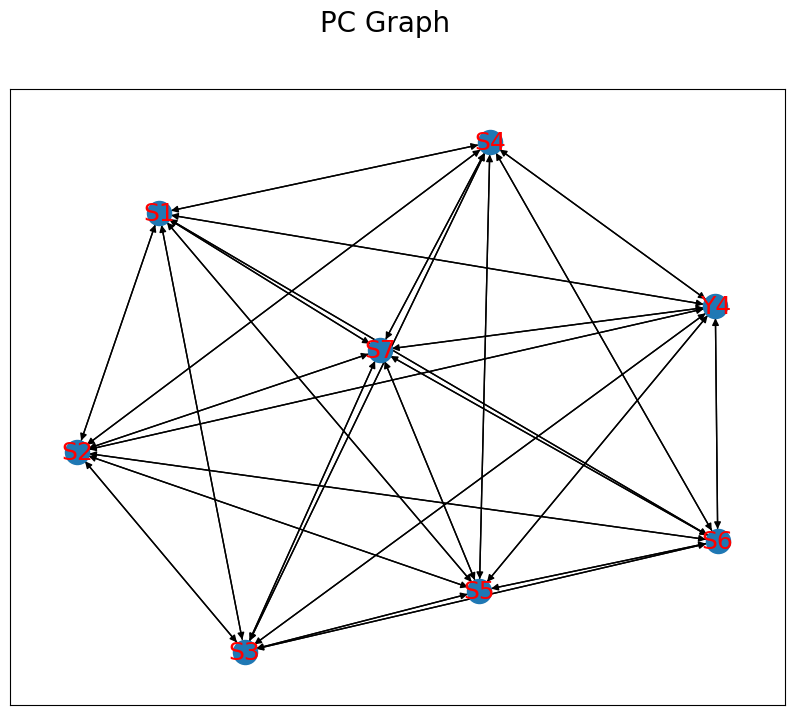

In [264]:
model_pc = cdt.causality.graph.PC()
graph_pc = model_pc.predict(df, skeleton)
# visualize network
fig = plt.figure(figsize=figsize)
fig.suptitle("PC Graph", fontsize=20)
nx.draw_networkx(graph_pc, font_size=18, font_color="r")

GES is ran on the skeleton of the given graph.


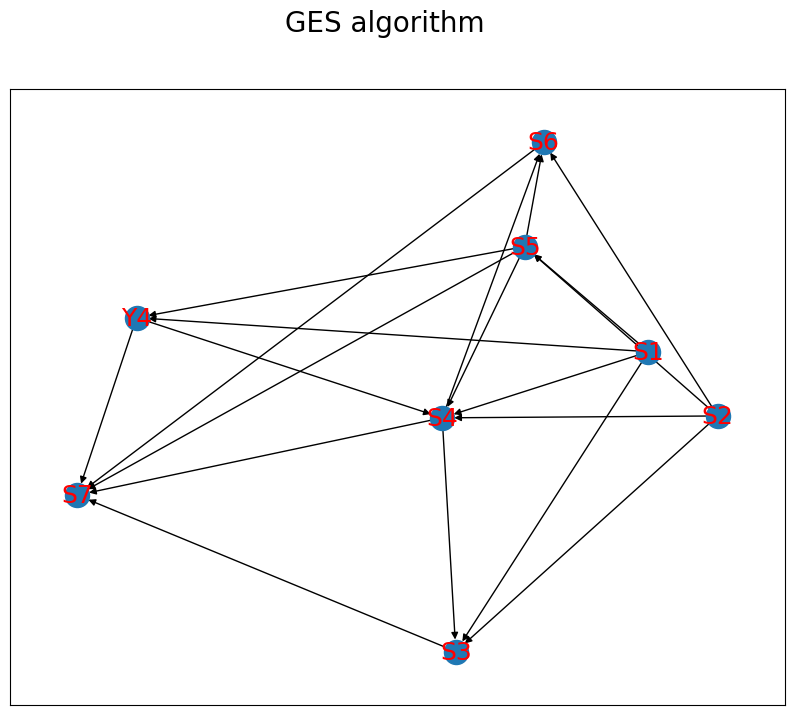

In [265]:
# GES algorithm
model_ges = cdt.causality.graph.GES()
graph_ges = model_ges.predict(df, skeleton)
# visualize network
fig = plt.figure(figsize=figsize)
fig.suptitle("GES algorithm", fontsize=20)
nx.draw_networkx(graph_ges, font_size=18, font_color="r")

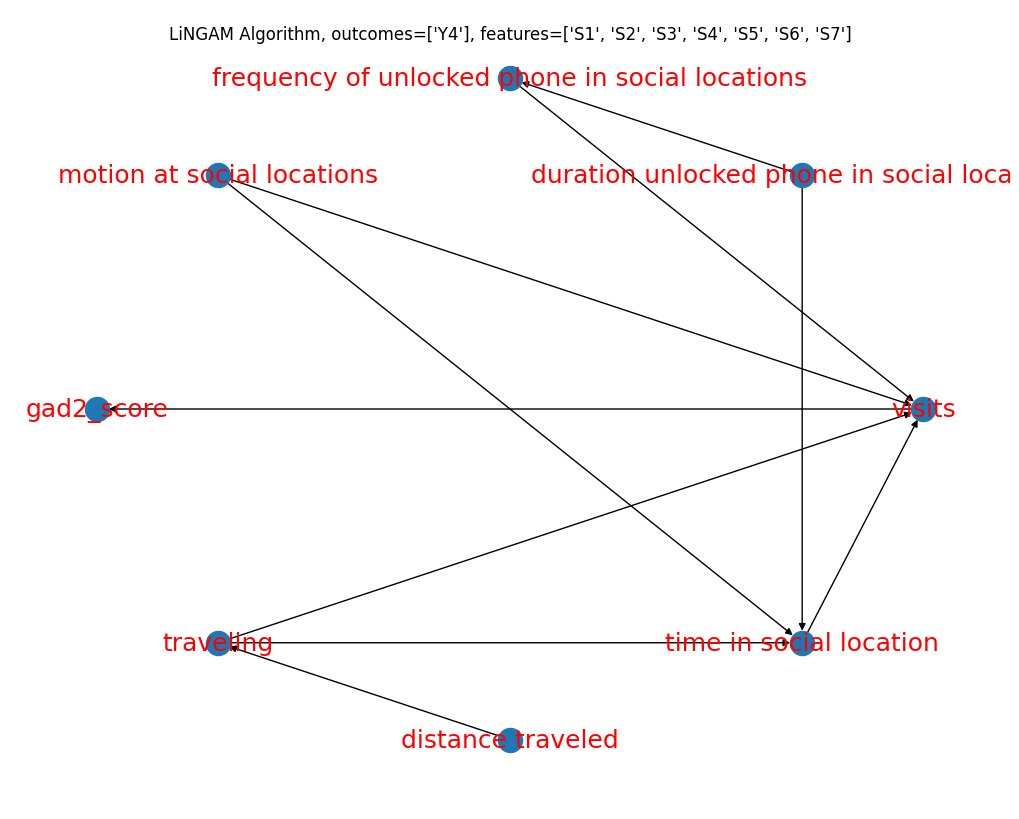

In [276]:
def get_font_color(node):
    # For example, nodes with odd numbers get red, even get blue
    if node == "Y1":
        return "blue"
    else:
        return "red"


# LiNGAM Algorithm
model_lingam = cdt.causality.graph.LiNGAM()
graph_lingam = model_lingam.predict(df)

# visualize network
fig = plt.figure(figsize=figsize)
fig.suptitle(f"LiNGAM Algorithm, outcomes={outcomes}, features={features}")

# pos = nx.spring_layout(graph_lingam)
pos = nx.shell_layout(graph_lingam)
# pos = nx.spectral_layout(graph_lingam)
# pos = nx.kamada_kawai_layout(graph_lingam)

nx.draw(graph_lingam, pos, with_labels=False)

# Draw the node labels with custom font colors
for node, label in draw_dictionary.items():
    nx.draw_networkx_labels(
        graph_lingam,
        pos,
        font_color="r",
        labels={node: draw_dictionary[node]},
        font_size=18,
    )
fig.savefig(f"../archive/lingam_network.png")
# nx.draw_networkx(graph_lingam, font_size=18, font_color="r")
# pass

In [269]:
draw_dictionary

{'S1': 'traveling',
 'S2': 'distance traveled',
 'S3': 'time in social location',
 'S4': 'visits',
 'S5': 'duration unlocked phone in social locations',
 'S6': 'frequency of unlocked phone in social locations',
 'S7': 'motion at social locations',
 'Y4': 'gad2_score'}